In [1]:
%matplotlib inline

from fastai.structured import *
from fastai.imports import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from IPython.display import display
from sklearn import metrics

In [2]:
set_plot_sizes(12,14,16)

In [3]:
??set_plot_sizes

In [4]:
df_raw = pd.read_csv('./Train.csv', parse_dates= ['saledate'], low_memory=False)

In [5]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [6]:
add_datepart(df_raw, 'saledate')

In [7]:
train_cats(df_raw)

In [8]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [9]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [10]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [11]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_trn = len(df) - n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [12]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train),y_train), rmse(m.predict(X_valid),y_valid),
          m.score(X_train,y_train), m.score(X_valid,y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [13]:
set_rf_samples(50000)

In [14]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20594897564493764, 0.24782564707501903, 0.9113550297762675, 0.8903167093059682, 0.8943240995729473]


In [15]:
fi = rf_feat_importance(m, df); fi[:10] 

,cols,imp
5,YearMade,0.170120
13,ProductSize,0.102660
37,Coupler_System,0.089309
14,fiProductClassDesc,0.078722
2,ModelID,0.059159
38,Grouser_Tracks,0.054589
63,saleElapsed,0.051344
19,Enclosure,0.043775
10,fiSecondaryDesc,0.043170
39,Hydraulics_Flow,0.040661


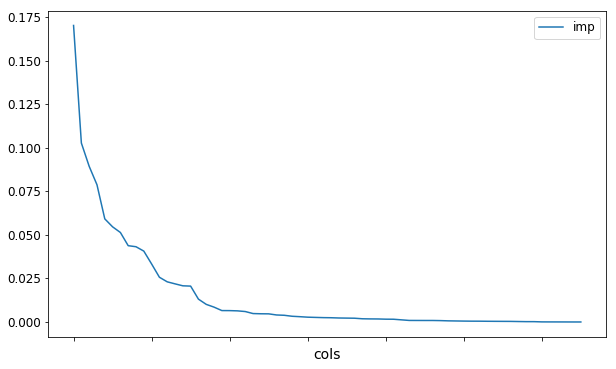

In [16]:
fi.plot('cols', 'imp', figsize=(10,6), legend=True)

In [17]:
reset_rf_samples()

In [18]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

In [19]:
def get_preds(t): return t.predict(X_valid)

preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

(9.184365818651264, 0.21962463109695118)

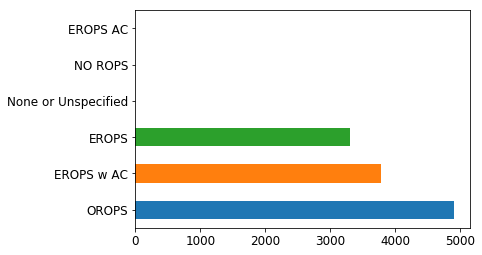

In [20]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [21]:
flds = ['Enclosure', 'SalePrice', 'pred_std', 'pred']
enc_summ = x[flds].groupby('Enclosure', as_index = False).mean()
enc_summ

,Enclosure,SalePrice,pred_std,pred
0,EROPS,9.849178,0.273279,9.836237
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,0.262699,10.580129
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,0.222858,9.685327


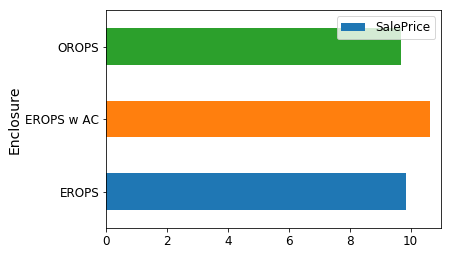

In [22]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

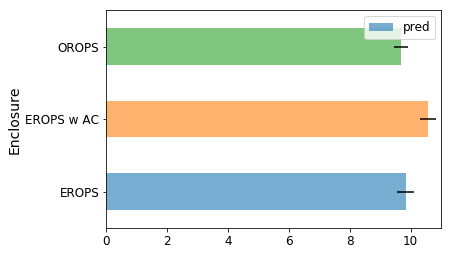

In [23]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', 
              alpha=0.6, xlim=(0,11));

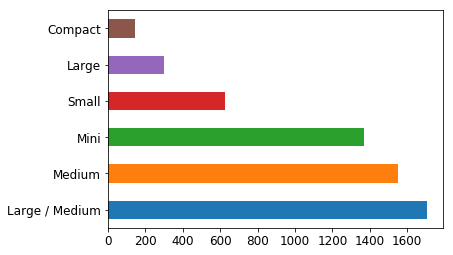

In [24]:
raw_valid.ProductSize.value_counts().plot.barh();

In [25]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.843277,0.337101
Large,10.470589,10.387972,0.340340
Large / Medium,10.691871,10.645299,0.295567
Medium,10.681511,10.626503,0.283148
Mini,9.535147,9.560392,0.247690
Small,10.324448,10.318671,0.307785


In [26]:
(summ.pred_std/summ.pred).sort_values(ascending = False)

ProductSize
Compact           0.034247
Large             0.032763
Small             0.029828
Large / Medium    0.027765
Medium            0.026645
Mini              0.025908
dtype: float64

In [27]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
5,YearMade,0.170120
13,ProductSize,0.102660
37,Coupler_System,0.089309
14,fiProductClassDesc,0.078722
2,ModelID,0.059159
38,Grouser_Tracks,0.054589
63,saleElapsed,0.051344
19,Enclosure,0.043775
10,fiSecondaryDesc,0.043170
39,Hydraulics_Flow,0.040661


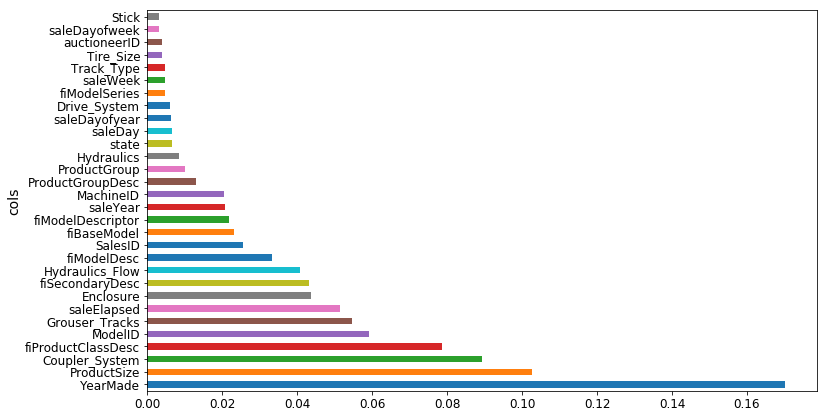

In [28]:
fi[:30].plot('cols','imp','barh', figsize=(12,7), legend=False)

In [29]:
to_keep = fi[fi.imp>0.005].cols;

df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12482215918804535, 0.22495755107599133, 0.9674374649841384, 0.9096248304396187, 0.9098620829510692]


In [30]:
fi = rf_feat_importance(m, df_keep)
fi

,cols,imp
0,YearMade,0.174284
2,Coupler_System,0.112162
1,ProductSize,0.105575
3,fiProductClassDesc,0.091353
6,saleElapsed,0.054205
4,ModelID,0.053359
5,Grouser_Tracks,0.052236
8,fiSecondaryDesc,0.044505
10,fiModelDesc,0.038948
7,Enclosure,0.037749


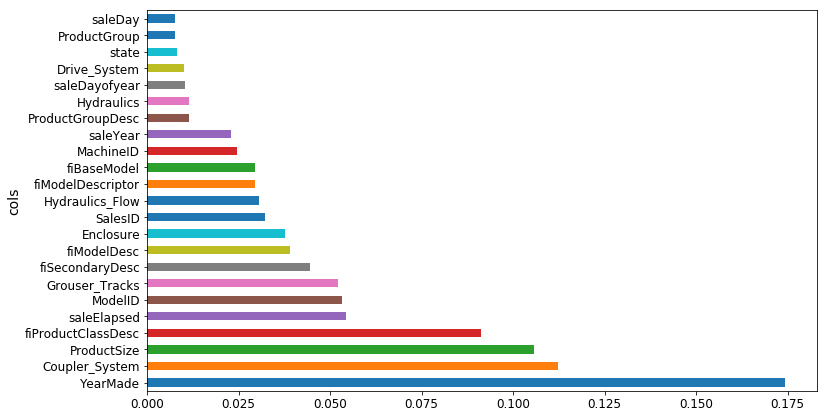

In [31]:
fi.plot('cols','imp','barh', figsize=(12,7), legend=False)

In [32]:
df_raw.YearMade.corr(df_raw.SalePrice)

0.182513813483776

In [33]:
df_raw.YearMade.dtype

dtype('int64')

### One-hot encoding

In [35]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)

X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11804078556189582, 0.2342474470597865, 0.9708794878856832, 0.9020064013121505, 0.9104083423463064]


### Feature Importance after one-hot

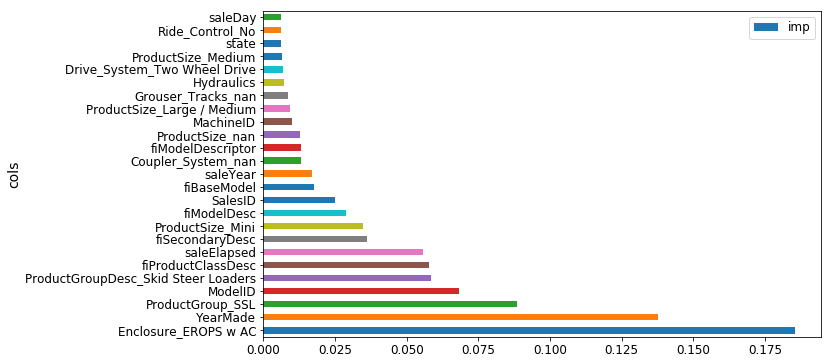

In [38]:
fi = rf_feat_importance(m, df_trn2)
fi[:25].plot('cols', 'imp', 'barh', figsize=(10,6))

### Removing redundant features using agglomerative clustering

In [40]:
from scipy.cluster import hierarchy as hc

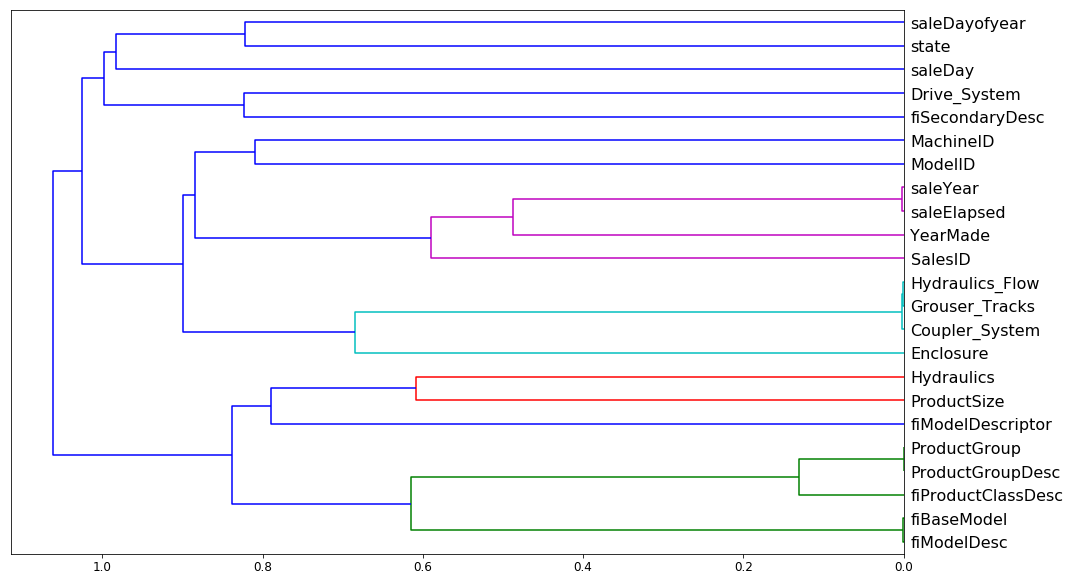

In [41]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [42]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, n_jobs=-1, max_features=0.6,
                              min_samples_leaf=5, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [43]:
get_oob(df_keep)

0.9066016497074443

In [47]:
for column in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks',
              'Coupler_System'):
    print(column, get_oob(df_keep.drop(column, axis=1)))

/home/orange/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


saleYear 0.9060638236615364


/home/orange/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


saleElapsed 0.90432135296753


/home/orange/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


fiModelDesc 0.9055055932483833
fiBaseModel 0.9063626772224009


/home/orange/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Grouser_Tracks 0.9062471470785631
Coupler_System 0.9070299620850086


In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.9059248740105892

In [50]:
df_keep.drop(to_drop, axis=1)
X_train, X_valid = split_vals(df_keep, n_trn)

In [54]:
np.save('./tmp/keep_cols.npy', np.array(df_keep.columns))

In [55]:
reset_rf_samples()

In [57]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12481890296843982, 0.2245971742749124, 0.9674391638713008, 0.909914156375671, 0.909814006000474]


In [61]:
from pdpbox import pdp
from plotnine import *

In [62]:
set_rf_samples(50000)

In [64]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, max_features=0.6, min_samples_leaf=3,
                          n_jobs=-1)
m.fit(X_train, y_train);

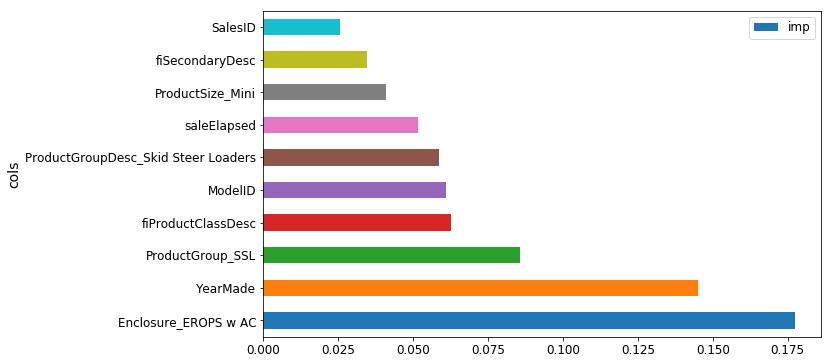

In [68]:
rf_feat_importance(m, df_trn2)[:10].plot('cols', 'imp', 'barh', figsize=(10,6))

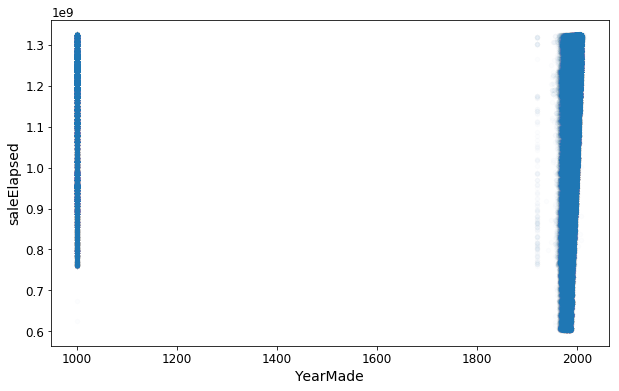

In [69]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize = (10,6))

In [70]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

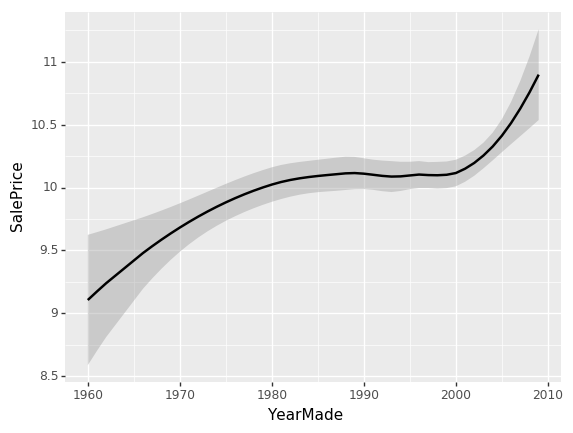

<ggplot: (8736150984438)>

In [72]:
ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method='loess')

In [73]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [76]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                       cluster=clusters is not None,
                       n_cluster_centers = clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f20b4d563c8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f20a5fb9ba8>})

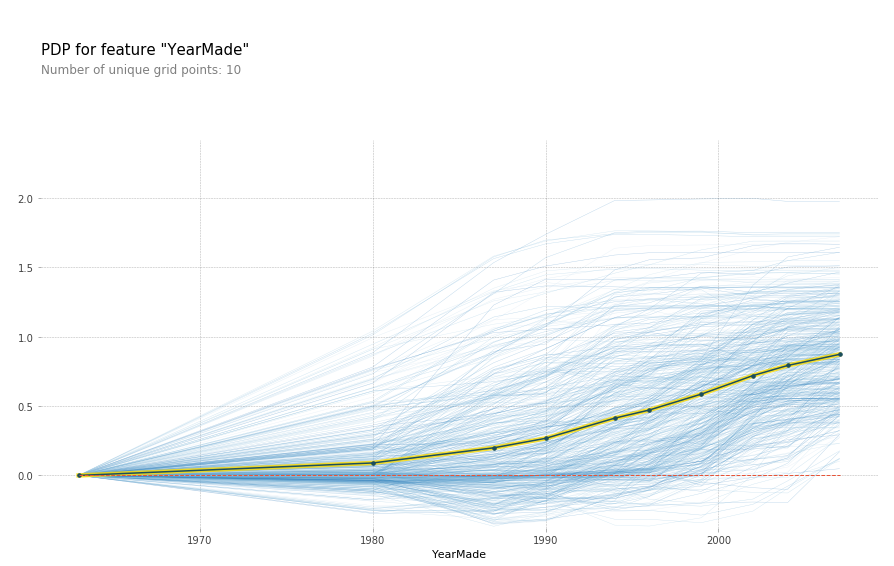

In [77]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f20a5fd3470>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f20ae6d02e8>})

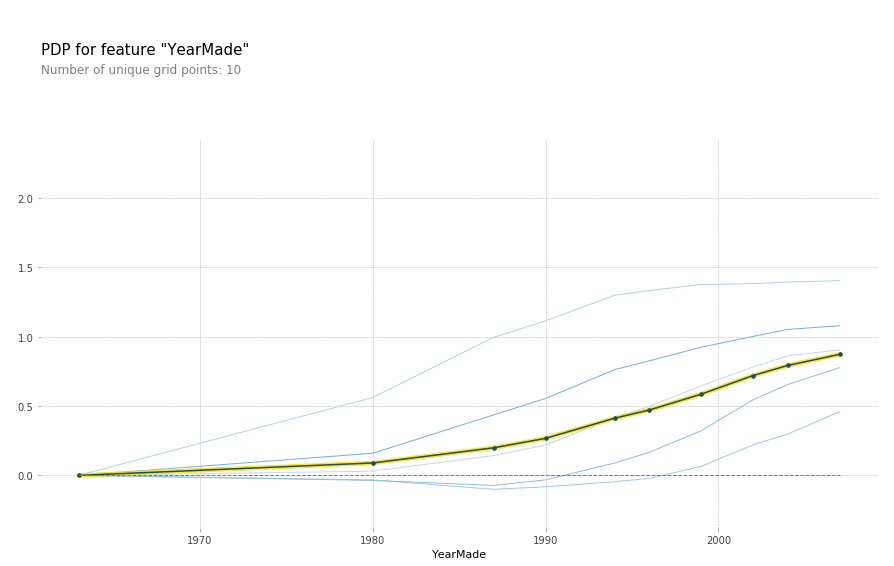

In [78]:
plot_pdp('YearMade', clusters=5)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f20a5f82da0>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f20ae58ccc0>})

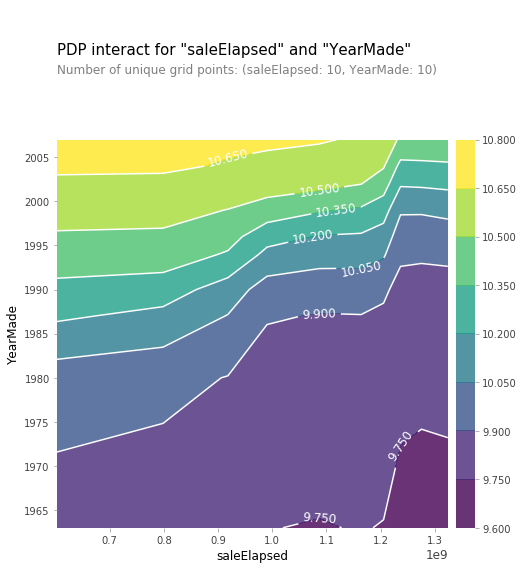

In [79]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f20ae4dd780>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f20ae4e2e10>})

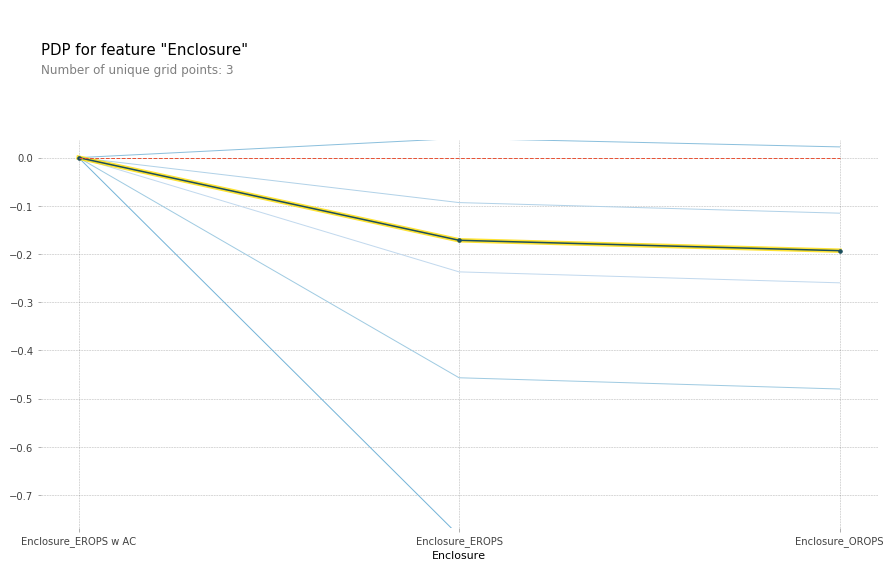

In [80]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [81]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear - df_raw.YearMade

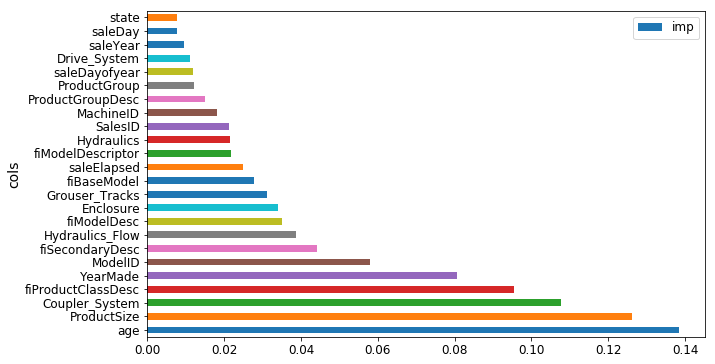

In [82]:
X_train, X_valid  = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, max_features=0.5, min_samples_leaf=3, n_jobs=-1)
m.fit(X_train, y_train)
rf_feat_importance(m, df_keep).plot('cols', 'imp', 'barh', figsize=(10,6))

In [83]:
from treeinterpreter import treeinterpreter as ti

In [84]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [85]:
row = X_valid.values[None,0]; row

array([[      1999,          5,          0,         17,        665,          0, 1284595200,          1,
                 0,          0,       3232,    4364751,       1111,          0,       2010,    2300944,
                 4,          4,         12,         35,         16,        259,          0,         11]])

In [87]:
prediction, bias, contributions = ti.predict(m, row)

In [88]:
prediction[0], bias[0]

(9.345347078361069, 10.105676848304169)

In [89]:
idxs = np.argsort(contributions[0])

In [90]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.4650079514009242),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.1335245817829621),
 ('age', 11, -0.1122365006395221),
 ('fiSecondaryDesc', nan, -0.05280665480641433),
 ('fiBaseModel', 'KX121', -0.051378979539366834),
 ('fiModelDesc', 'KX1212', -0.04856810598443077),
 ('Enclosure', 'EROPS', -0.04588802408460717),
 ('fiModelDescriptor', nan, -0.03725213746692222),
 ('saleElapsed', 1284595200, -0.035955096992526726),
 ('saleYear', 2010, -0.024174110527572745),
 ('MachineID', 2300944, -0.02405017177667048),
 ('saleDayofyear', 259, -0.008464437354101007),
 ('SalesID', 4364751, -0.006624439794524317),
 ('ProductGroup', 'TEX', -0.00615660273530585),
 ('Drive_System', nan, 0.006153808917466907),
 ('saleDay', 16, 0.007507914319507281),
 ('state', 'Ohio', 0.010172908609619969),
 ('Hydraulics_Flow', nan, 0.013200161234167318),
 ('ProductGroupDesc', 'Track Excavators', 0.015686678867515357),
 ('Grouser_Tracks', nan, 0.01594130911

In [92]:
contributions[0].sum() 

-0.760329769943099

In [100]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x , y, nas = proc_df(df_ext, 'is_valid')

In [102]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                           n_jobs=-1, oob_score=True)
m.fit(x,y)
m.oob_score_

0.9999825490807105

In [104]:
??m.oob_score_

In [106]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.839150
6,saleElapsed,0.067911
14,saleYear,0.051656
15,MachineID,0.020186
21,saleDayofyear,0.014539
0,YearMade,0.001744
10,fiModelDesc,0.001356
4,ModelID,0.001171
12,fiBaseModel,0.001005
9,Hydraulics_Flow,0.000291


In [107]:
feats = ['SalesID', 'saleElapsed', 'MachineID']

In [108]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [109]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [111]:
x.drop(feats, axis=1, inplace=True)

In [112]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                           n_jobs=-1, oob_score=True)
m.fit(x,y)
m.oob_score_

0.9847628544717981

In [113]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
12,saleYear,0.301765
18,saleDayofyear,0.272584
4,ModelID,0.058424
17,saleDay,0.049982
9,fiModelDesc,0.040863
16,state,0.039388
0,YearMade,0.034087
10,fiBaseModel,0.031584
20,age,0.031551
6,Enclosure,0.024568


In [114]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [115]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.2074004974538073, 0.24378338722017703, 0.910101092595681, 0.893865595379234, 0.8941305802951285]
saleElapsed
[0.20892368582020468, 0.24839980147394605, 0.9087757746492462, 0.8898078992294693, 0.8923757956778889]
MachineID
[0.20553425125112645, 0.24237885840569673, 0.9117116833204253, 0.8950850337509841, 0.8962424974865003]
age
[0.2069400616350723, 0.24636523017219272, 0.9104998064946365, 0.8916056102710708, 0.8942750168082526]
YearMade
[0.20708199004331657, 0.24868709379635742, 0.9103769982195895, 0.8895528615735837, 0.8940537013913756]
saleDayofyear
[0.20785522113014085, 0.2433387597984557, 0.9097064554008044, 0.8942523914848831, 0.8937675295538514]


In [117]:
reset_rf_samples()

In [118]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13745520639994313, 0.21549363839018365, 0.960512720419529, 0.9170690039290389, 0.9099431958019034]


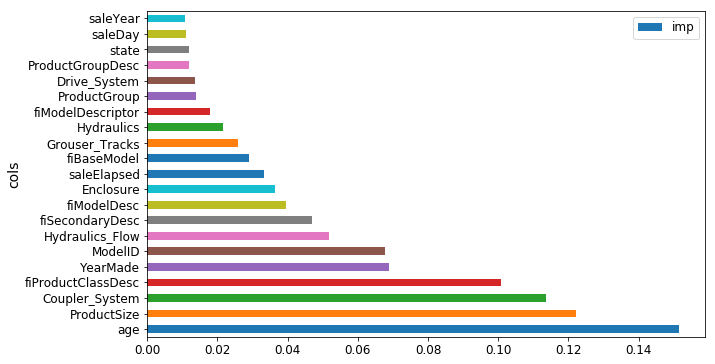

In [120]:
rf_feat_importance(m, X_train)[:25].plot('cols', 'imp', 'barh', figsize=(10,6))

In [121]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

In [122]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 34s, sys: 2.45 s, total: 5min 37s
Wall time: 1min 49s
[0.08015463821983743, 0.2100429198736356, 0.986572593323934, 0.9212112758570299, 0.914981519018934]
